In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-5b78is3y
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-5b78is3y
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit fb2becacbf3c48249ce960f3ef60a862f8fc6707
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-lq6r2nc_/elegantrl_1e2fe6459c4a4b25bd084403c99b6b39
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-lq6r2nc_/elegantrl_1e2fe6459c4a4b25bd084403c99b6b39
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit b2ec84b19a82e6f18b781743d8bf37ca27134238
  Preparing metadata (setup.py) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
import itertools
%matplotlib inline

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/SympactAI_Testing_Data/train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

test = pd.read_csv('/content/drive/MyDrive/SympactAI_Testing_Data/test_data.csv')
test = test.set_index(test.columns[0])
test.index.names = ['']

In [5]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [7]:
trained_a2c = A2C.load("/content/drive/MyDrive/SympactAI_Testing_Data/trained_models/agent_a2c_10000.zip") if if_using_a2c else None
trained_ddpg = DDPG.load("/content/drive/MyDrive/SympactAI_Testing_Data/trained_models/agent_ddpg_10000.zip") if if_using_ddpg else None
trained_ppo = PPO.load("/content/drive/MyDrive/SympactAI_Testing_Data/trained_models/agent_ppo_10000.zip") if if_using_ppo else None
trained_td3 = TD3.load("/content/drive/MyDrive/SympactAI_Testing_Data/trained_models/agent_td3_10000.zip") if if_using_td3 else None
trained_sac = SAC.load("/content/drive/MyDrive/SympactAI_Testing_Data/trained_models/agent_sac_10000.zip") if if_using_sac else None

In [8]:
stock_dimension = len(test.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [9]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [10]:
e_trade_gym = StockTradingEnv(df = test, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [11]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [12]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [13]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [14]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [15]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


In [16]:
df_account_value_ddpg_rw = pd.read_csv('/content/drive/MyDrive/SympactAI_Testing_Data/ddpg_rw_results_actions/result_ddpg_rw.csv')
df_account_value_ddpg_rw = df_account_value_ddpg_rw[['date', 'DDPG']].rename(columns={'DDPG': 'account_value'})


In [17]:
def process_df_for_mvo(df):
  return df.pivot(index="date", columns="tic", values="close")

In [18]:

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [19]:
StockData = process_df_for_mvo(train)
TestData = process_df_for_mvo(test)

TestData.to_numpy()

array([[215.74104309, 301.29083252, 230.61296082, ...,  38.48230743,
         10.97675896,  66.79409027],
       [219.24465942, 301.05831909, 232.74342346, ...,  37.89225006,
         10.96727943,  67.3780899 ],
       [220.51870728, 299.71176147, 232.48696899, ...,  37.91069031,
         10.5217638 ,  67.5463562 ],
       ...,
       [201.55999756, 280.3500061 , 307.81286621, ...,  41.44979477,
         11.31000042,  97.26000214],
       [201.        , 279.10998535, 310.63574219, ...,  41.43011475,
         11.38000011,  96.01999664],
       [201.08000183, 277.13000488, 316.39120483, ...,  41.63677597,
         11.44999981,  97.26999664]])

In [20]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.111  0.067  0.07   0.065  0.075  0.098  0.042  0.049  0.048  0.049
  0.089  0.066  0.032  0.041  0.04   0.068  0.04   0.056  0.033  0.056
  0.094  0.062  0.045  0.058  0.095  0.083  0.034 -0.001  0.052]
Variance-Covariance matrix of returns
 [[3.13  0.933 1.339 1.553 1.302 1.79  1.353 1.032 1.18  1.336 1.205 1.19
  0.976 1.624 0.635 1.223 0.663 0.799 1.018 0.658 1.688 1.297 0.659 0.79
  1.061 1.356 0.51  0.961 0.623]
 [0.933 2.322 0.979 0.887 0.975 1.063 0.941 0.837 0.84  1.022 0.904 0.946
  0.791 1.062 0.841 1.019 0.614 0.623 0.865 0.974 0.97  0.8   0.678 0.782
  1.029 0.945 0.599 0.996 0.592]
 [1.339 0.979 3.348 2.419 1.871 1.633 1.376 1.737 1.744 2.155 1.367 1.732
  1.273 1.499 0.778 2.256 0.934 1.009 1.355 0.842 1.379 1.485 0.695 1.416
  1.286 1.779 0.714 1.235 0.566]
 [1.553 0.887 2.419 5.098 2.037 1.752 1.41  1.921 1.87  2.11  1.471 2.001
  1.375 1.771 0.793 2.143 1.016 1.134 1.407 0.799 1.421 1.663 0.687 1.463
  1.322 1.643 0.689 1.37

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])
mvo_weights

array([230560.,  15940.,      0.,      0.,      0.,   9050.,      0.,
            0.,      0.,      0., 174080.,      0.,      0.,      0.,
            0.,      0.,      0.,  42940.,      0.,  68800.,  70160.,
            0.,      0.,      0., 225410.,  39040.,      0.,      0.,
       124010.])

In [22]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1099.792,   52.662,    0.   ,    0.   ,    0.   ,   35.462,
          0.   ,    0.   ,    0.   ,    0.   ,  517.889,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  172.455,
          0.   ,  574.498,  158.179,    0.   ,    0.   ,    0.   ,
        450.98 ,  149.822,    0.   ,    0.   , 1850.295])

In [23]:
Portfolio_Assets = TestData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
date,
2024-07-01,9.987478e+05
2024-07-02,1.005313e+06
2024-07-03,1.002433e+06
2024-07-05,1.012559e+06
2024-07-08,1.014757e+06
...,...
2025-06-23,9.712082e+05
2025-06-24,9.769488e+05
2025-06-25,9.741102e+05


In [24]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2024-07-01'
TRADE_START_DATE = '2024-07-01'
TRADE_END_DATE = '2025-07-01'


In [25]:
df_dji = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["djia"]
).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (250, 8)


In [26]:
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

In [33]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)

df_result_ddpg_rw = (
    df_account_value_ddpg_rw.set_index(df_account_value_ddpg_rw.columns[0])
    if if_using_ddpg
    else None
)

df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ddpg_rw": df_result_ddpg_rw["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
        "mvo": MVO_result["Mean Var"],
        "dji": dji["close"],
    }
)

In [34]:
result


,a2c,ddpg,ddpg_rw,ppo,td3,sac,mvo,dji
date,,,,,,,,
2024-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,9.987478e+05,1.000000e+06
2024-07-02,1.000356e+06,1.000623e+06,1.000851e+06,1.000009e+06,1.001169e+06,1.000959e+06,1.005313e+06,9.981966e+05
2024-07-03,1.000712e+06,1.000018e+06,1.000714e+06,9.999804e+05,1.000729e+06,1.000722e+06,1.002433e+06,9.986475e+05
2024-07-05,1.002312e+06,1.003610e+06,1.004677e+06,1.000069e+06,1.001517e+06,1.000236e+06,1.012559e+06,1.002254e+06
2024-07-08,1.001272e+06,1.003819e+06,1.002525e+06,1.000196e+06,1.001797e+06,1.001296e+06,1.014757e+06,1.004960e+06
...,...,...,...,...,...,...,...,...
2025-06-24,1.177583e+06,1.014103e+06,1.289730e+06,1.042062e+06,1.124400e+06,1.218693e+06,9.769488e+05,1.095131e+06
2025-06-25,1.180442e+06,1.007149e+06,1.286160e+06,1.042105e+06,1.122044e+06,1.209582e+06,9.741102e+05,1.097168e+06
2025-06-26,1.192426e+06,1.012469e+06,1.300120e+06,1.048563e+06,1.134068e+06,1.215089e+06,9.728262e+05,1.100732e+06


In [ ]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import datetime
from finrl import config

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_ppo_.csv")

if if_using_ddpg:
  print("\n ddpg:")
  perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
  perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
  perf_stats_all_ddpg.to_csv("/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_ddpg_.csv")

# backtesting ddpg after rolling window technique
if if_using_ddpg:
  print("\n ddpg after rolling window:")
  perf_stats_all_ddpg_rw = backtest_stats(account_value=df_account_value_ddpg_rw)
  perf_stats_all_ddpg_rw = pd.DataFrame(perf_stats_all_ddpg_rw)
  perf_stats_all_ddpg_rw.to_csv("/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_ddpg_rw.CSV")



if if_using_a2c:
  print("\n a2c:")
  perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
  perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
  perf_stats_all_a2c.to_csv("/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_a2c_.csv")

if if_using_td3:
  print("\n td3:")
  perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
  perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
  perf_stats_all_td3.to_csv("/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_td3_.csv")

if if_using_sac:
  print("\n sac:")
  perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
  perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
  perf_stats_all_sac.to_csv("/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_sac_.csv")



==============Get Backtest Results===========

 ppo:
Annual return          0.095350
Cumulative returns     0.094163
Annual volatility      0.177640
Sharpe ratio           0.602892
Calmar ratio           0.575186
Stability              0.142654
Max drawdown          -0.165773
Omega ratio            1.114901
Sortino ratio          0.912430
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.962436
Daily value at risk   -0.021956
dtype: float64

 ddpg:
Annual return          0.174497
Cumulative returns     0.172250
Annual volatility      0.194663
Sharpe ratio           0.926198
Calmar ratio           0.858389
Stability              0.187359
Max drawdown          -0.203284
Omega ratio            1.196973
Sortino ratio          1.390335
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912482
Daily value at risk   -0.023810
dtype: float64

 ddpg after rolling window:
Annual return          0.305635
Cumulative retur

In [30]:
import pandas as pd

# Paths to your CSVs
files = {
    "PPO": "/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_ppo_.csv",
    "DDPG": "/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_ddpg_.csv",
    "DDPG_RW": "/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_ddpg_rw.CSV",
    "A2C": "/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_a2c_.csv",
    "TD3": "/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_td3_.csv",
    "SAC": "/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/perf_stats_all_sac_.csv"
}

dfs = []
for model, path in files.items():
    df = pd.read_csv(path, index_col=0)   # Index is metric names
    df.columns = [model]                  # Rename the only column to model name
    dfs.append(df)

# Merge all into one comparative table
merged_df = pd.concat(dfs, axis=1)

# Save comparative table
merged_df.to_csv("/content/drive/MyDrive/SympactAI_Testing_Data/final_stats_results/comparative_metrics.csv")

print("Merged comparative table saved!")


Merged comparative table saved!


In [32]:
merged_df.head(15)

,PPO,DDPG,DDPG_RW,A2C,TD3,SAC
Annual return,0.095350,0.174497,0.305635,-0.072928,0.090243,0.096515
Cumulative returns,0.094163,0.172250,0.300120,-0.072092,0.089122,0.095313
Annual volatility,0.177640,0.194663,0.171232,0.204438,0.153995,0.195371
Sharpe ratio,0.602892,0.926198,1.648725,-0.268240,0.640076,0.570602
Calmar ratio,0.575186,0.858389,2.591312,-0.313387,0.768363,0.480773
Stability,0.142654,0.187359,0.793150,0.501208,0.067046,0.002717
Max drawdown,-0.165773,-0.203284,-0.117946,-0.232710,-0.117448,-0.200749
Omega ratio,1.114901,1.196973,1.366060,0.947562,1.122963,1.102106
Sortino ratio,0.912430,1.390335,2.759849,-0.334284,0.916437,0.849897
Skew,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

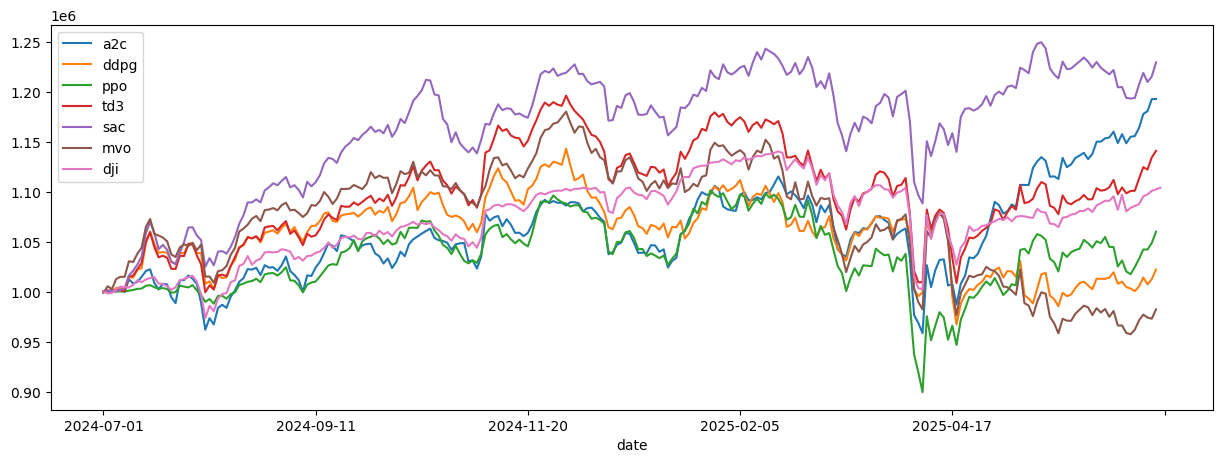

In [29]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()